## Imports

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from random import seed
from tqdm import tqdm
from time import time
import dask
from dask.distributed import Client, LocalCluster


import torch
import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.model.model import DeepSensorModel
from deepsensor.train.train import train_epoch, set_gpu_default_device

from aqmsp_data.data import load_caaqm, load_camx, load_station_ds, load_shapefile

# import dask
# from dask.distributed import Client, LocalCluster

import xarray as xr
import pandas as pd
import numpy as np
from polire import IDW, Kriging

import seaborn as sns
import matplotlib.pyplot as plt

set_gpu_default_device()

In [2]:
if "client" in locals():
    client.close()
cluster = LocalCluster(n_workers=48)
client = Client(cluster)


## Load data

In [3]:
simulation_ds = load_camx(years=2022, months=(1, 2), variables="P25")
simulation_ds


 /home/patel_zeel/miniconda3/envs/active_learn/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning:Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]


<xarray.Dataset>
Dimensions:    (time: 1416, latitude: 80, longitude: 80)
Coordinates:
  * longitude  (longitude) float64 76.85 76.86 76.87 76.88 ... 77.62 77.63 77.64
  * latitude   (latitude) float64 28.2 28.21 28.22 28.23 ... 28.97 28.98 28.99
  * time       (time) time64[ns] 2022-01-01T00:30:00 ... 2022-02-28T23:30:00
Data variables:
    P25        (time, latitude, longitude) float32 dask.array<chunksize=(1416, 80, 80), meta=np.ndarray>
Attributes: (12/34)
    CDATE:          2023126
    CTIME:          95909
    EXEC_ID:        ????????????????                                         ...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    FTYPE:          1
    GDNAM:          ????????????????
    ...             ...
    XCELL:          0.009999999776482582
    XCENT:          0.0
    XORIG:          76.8499984741211
    YCELL:          0.009999999776482582
    YCENT:          0.0
    YORIG:          28.200000762939453

## Divide into train and test

In [4]:
train_start = "2022-01-01 00:00:00"
train_end = "2022-01-31 23:59:59"
test_start = "2022-02-01 00:00:00"
test_end = "2022-02-28 23:59:59"

simulation_train_ds = simulation_ds.sel(time=slice(train_start, train_end))
simulation_test_ds = simulation_ds.sel(time=slice(test_start, test_end))

print("Train Sizes")
print(
    # "Station: ",
    # station_train_ds.time.size,
    "Simulation: ",
    simulation_train_ds.time.size,
)
print("Test Sizes")
print(
    # "Station: ", station_test_ds.time.size,
    "Simulation: ",
    simulation_test_ds.time.size,
)

Train Sizes
Simulation:  744
Test Sizes
Simulation:  672


## Data processor

In [5]:
min_lat, max_lat = (
    simulation_ds.latitude.min().item(),
    simulation_ds.latitude.max().item(),
)
min_lon, max_lon = (
    simulation_ds.longitude.min().item(),
    simulation_ds.longitude.max().item(),
)

In [6]:
data_processor = DataProcessor(
    x1_name="latitude",
    x1_map=(min_lat, max_lat),
    x2_name="longitude",
    x2_map=(min_lon, max_lon),
)
scaled_train_ds = data_processor(simulation_train_ds)
scaled_train_ds


<xarray.Dataset>
Dimensions:  (time: 744, x1: 80, x2: 80)
Coordinates:
  * x2       (x2) float64 0.0 0.01266 0.02532 0.03797 ... 0.9747 0.9873 1.0
  * x1       (x1) float64 0.0 0.01266 0.02532 0.03797 ... 0.9747 0.9873 1.0
  * time     (time) time64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
Data variables:
    P25      (time, x1, x2) float32 0.2623 0.2623 0.3231 ... 0.9378 0.9378
Attributes: (12/34)
    CDATE:          2023126
    CTIME:          95909
    EXEC_ID:        ????????????????                                         ...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    FTYPE:          1
    GDNAM:          ????????????????
    ...             ...
    XCELL:          0.009999999776482582
    XCENT:          0.0
    XORIG:          76.8499984741211
    YCELL:          0.009999999776482582
    YCENT:          0.0
    YORIG:          28.200000762939453

## Set up taskloader

In [7]:
task_loader = TaskLoader(context=scaled_train_ds, target=scaled_train_ds)
task_loader

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('P25',),)
Target variable IDs: (('P25',),)

Context data dimensions: (1,)
Target data dimensions: (1,)

## Generate context-target pairs

In [8]:
train_tasks = []
np.random.seed(0)
for date in tqdm(scaled_train_ds.time.values):
    task = task_loader(
        date,
        context_sampling=np.random.uniform(0.0, 0.1),
        target_sampling="all",
        seed_override=0,
    )
    train_tasks.append(task)

100%|██████████| 744/744 [00:04<00:00, 183.11it/s]


In [9]:
train_tasks[0]


time: Timestamp/2022-01-01 00:30:00
flag: NoneType/None
X_c: ['ndarray/float32/(2, 351)']
Y_c: ['ndarray/float32/(1, 351)']
X_t: [('ndarray/float32/(1, 80)', 'ndarray/float32/(1, 80)')]
Y_t: ['ndarray/float32/(1, 80, 80)']

## Train

In [10]:
model = ConvNP(data_processor, task_loader, likelihood="gnp")
batch_size = 32

# Train model
pbar = tqdm(range(50))
losses = []
for epoch in pbar:
    batch_loss = train_epoch(
        model, train_tasks, progress_bar=False, batch_size=batch_size
    )
    pbar.set_description(f"Loss: {np.mean(batch_loss):.4f}")
    losses.append(np.mean(batch_loss))


dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
points_per_unit inferred from TaskLoader: 94
encoder_scales inferred from TaskLoader: [0.006329114083200692]
decoder_scale inferred from TaskLoader: 0.010638297872340425


Loss: -0.4746: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


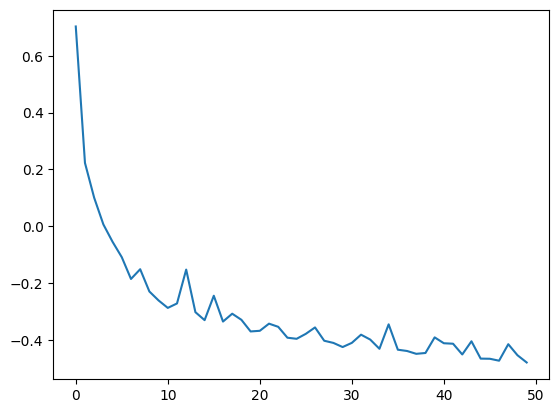

In [14]:
plt.plot(losses)


## Train loss

In [15]:
mean_ds, std_ds = model.predict(train_tasks, X_t=simulation_ds)
mean_ds

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) time64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
  * latitude   (latitude) float64 28.2 28.21 28.22 28.23 ... 28.97 28.98 28.99
  * longitude  (longitude) float64 76.85 76.86 76.87 76.88 ... 77.62 77.63 77.64
Data variables:
    P25        (time, latitude, longitude) float32 131.3 135.6 ... 123.7 120.9

15.532953262329102

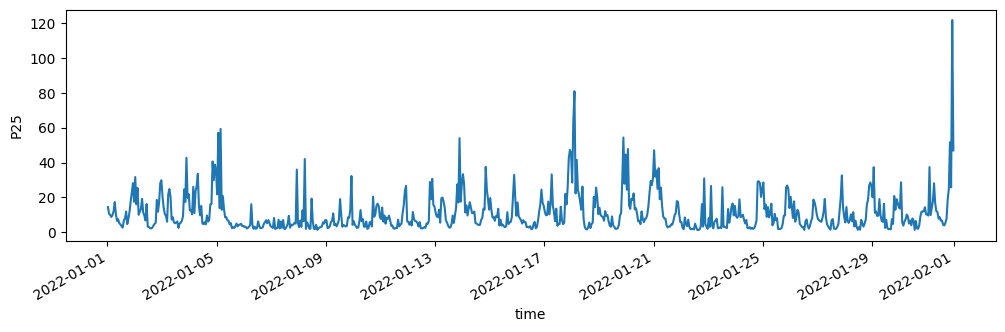

In [16]:
errors = np.abs(mean_ds - simulation_train_ds).mean(dim=["latitude", "longitude"])
errors["P25"].plot(figsize=(12, 3))
np.sqrt(np.square(errors["P25"]).mean(dim="time")).load().item()

## Test errors

In [41]:
class IDWModel(DeepSensorModel):
    def __init__(self, data_processor: DataProcessor, task_loader: TaskLoader):
        super().__init__(data_processor, task_loader)

    def mean(self, task):
        # simple baseline
        idw = IDW(exponent=2)
        idw.fit(task["X_c"][0].T, task["Y_c"][0].ravel())
        Lats, Lons = np.meshgrid(*task["X_t"][0])
        X_test = np.array([Lats.flatten(), Lons.flatten()]).T
        y_test = task["Y_t"][0].reshape(-1)
        y_pred = idw.predict(X_test).reshape(y_test.shape)
        return y_pred.reshape(task["Y_t"][0].shape)

    def stddev(self, task):
        return np.zeros_like(task["Y_t"][0])


class KrigingModel(DeepSensorModel):
    def __init__(self, data_processor: DataProcessor, task_loader: TaskLoader):
        super().__init__(data_processor, task_loader)

    def mean(self, task):
        # simple baseline
        krig = Kriging(variogram_model="spherical")
        krig.fit(task["X_c"][0].T, task["Y_c"][0].ravel())
        Lats, Lons = np.meshgrid(*task["X_t"][0])
        X_test = np.array([Lats.flatten(), Lons.flatten()]).T
        y_test = task["Y_t"][0].reshape(-1)
        y_pred = krig.predict(X_test).reshape(y_test.shape)
        return y_pred.reshape(task["Y_t"][0].shape)

    def stddev(self, task):
        return np.zeros_like(task["Y_t"][0])

In [36]:
task_loader??

Signature:      task_loader(date, *args, **kwargs)
Type:           TaskLoader
String form:   
TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('P25',),)
Target variable IDs: (('P25',),)
File:           ~/deepsensor/deepsensor/data/loader.py
Source:        
class TaskLoader:
    def __init__(
        self,
        context: Union[
            xr.DataArray,
            xr.Dataset,
            pd.DataFrame,
            List[Union[xr.DataArray, xr.Dataset, pd.DataFrame]],
        ],
        target: Union[
            xr.DataArray,
            xr.Dataset,
            pd.DataFrame,
            List[Union[xr.DataArray, xr.Dataset, pd.DataFrame]],
        ],
        aux_at_contexts: Tuple[int, Union[xr.DataArray, xr.Dataset]] = None,
        aux_at_targets: Union[
            xr.DataArray,
            xr.Dataset,
        ] = None,
        links: Union[Tuple, List[Tuple[int, int]], None] = None,
        context_delta_t: Union[int, List[int]] = 0,
        target_delta_t: Union[in

In [38]:
scaled_test_ds = data_processor(simulation_test_ds)
task_loader = TaskLoader(scaled_test_ds, scaled_test_ds)

res_df = pd.DataFrame(columns=["context_sampling", "seed", "rmse"]).set_index(
    ["context_sampling", "seed"]
)
idw_df = pd.DataFrame(columns=["context_sampling", "seed", "rmse"]).set_index(
    ["context_sampling", "seed"]
)
delayed = dask.delayed(task_loader)
for context_sampling in [0.01, 0.02, 0.05, 0.1]:
    print(f"Context Sampling: {context_sampling}")
    cnp_times = []
    idw_times = []
    for seed in range(5):
        print(f"{seed}", end=" ")
        np.random.seed(seed)
        test_tasks = []
        idw_ds_list = []
        create_init = time()
        for date in scaled_test_ds.time.values[: 24 * 7]:
            task = delayed(
                date,
                context_sampling=context_sampling,
                target_sampling="all",
                seed_override=seed,
            )
            test_tasks.append(task)
        print(f"Append Time: {time() - create_init:.2f}", end=" ")
        test_tasks = dask.compute(*test_tasks)
        print(f"Create Time: {time() - create_init:.2f}", end=" ")

        cnp_init = time()
        mean_ds, scale_ds = model.predict(test_tasks, simulation_test_ds)
        cnp_times.append(time() - cnp_init)
        errors = np.abs(mean_ds - simulation_test_ds).mean(
            dim={"latitude", "longitude"}
        )
        rmse = np.sqrt((errors**2).mean(dim="time"))["P25"].load().item()
        res_df.loc[(context_sampling, seed), "rmse"] = rmse

        # Idw
        idw_init = time()
        idw = IDWModel(data_processor, task_loader)
        mean_ds, scale_ds = idw.predict(test_tasks, simulation_test_ds)
        idw_times.append(time() - idw_init)
        errors = np.abs(mean_ds - simulation_test_ds).mean(
            dim={"latitude", "longitude"}
        )
        rmse = np.sqrt((errors**2).mean(dim="time"))["P25"].load().item()
        idw_df.loc[(context_sampling, seed), "rmse"] = rmse

    print("Sum of CNP Times: ", np.sum(cnp_times))
    print("Sum of IDW Times: ", np.sum(idw_times))


Context Sampling: 0.01
0 Append Time: 0.02 Create Time: 8.13 1 Append Time: 0.01 Create Time: 10.54 2 Append Time: 0.01 Create Time: 11.05 3 Append Time: 0.01 Create Time: 9.53 4 Append Time: 0.01 Create Time: 9.71 Sum of CNP Times:  24.748961687088013
Sum of IDW Times:  45.8721866607666
Context Sampling: 0.02
0 Append Time: 0.02 Create Time: 10.31 1 Append Time: 0.02 Create Time: 10.67 2 Append Time: 0.02 Create Time: 15.14 3 Append Time: 0.01 Create Time: 10.64 4 Append Time: 0.01 Create Time: 11.27 Sum of CNP Times:  24.969010591506958
Sum of IDW Times:  55.10239267349243
Context Sampling: 0.05
0 Append Time: 0.02 Create Time: 9.55 1 Append Time: 0.02 Create Time: 11.20 2 Append Time: 0.01 Create Time: 10.90 3 Append Time: 0.01 Create Time: 7.81 4 Append Time: 0.01 Create Time: 10.23 Sum of CNP Times:  25.183788537979126
Sum of IDW Times:  175.4933159351349
Context Sampling: 0.1
0 Append Time: 0.01 Create Time: 12.57 1 Append Time: 0.01 Create Time: 8.66 2 Append Time: 0.01 Create T

In [42]:
scaled_test_ds = data_processor(simulation_test_ds)
task_loader = TaskLoader(scaled_test_ds, scaled_test_ds)

# res_df = pd.DataFrame(columns=["context_sampling", "seed", "rmse"]).set_index(
#     ["context_sampling", "seed"]
# )
krig_df = pd.DataFrame(columns=["context_sampling", "seed", "rmse"]).set_index(
    ["context_sampling", "seed"]
)
delayed = dask.delayed(task_loader)
for context_sampling in [0.01, 0.02, 0.05, 0.1]:
    print(f"Context Sampling: {context_sampling}")
    # cnp_times = []
    krig_times = []
    for seed in range(5):
        print(f"{seed}", end=" ")
        np.random.seed(seed)
        test_tasks = []
        krig_ds_list = []
        create_init = time()
        for date in scaled_test_ds.time.values[: 24 * 7]:
            task = delayed(
                date,
                context_sampling=context_sampling,
                target_sampling="all",
                seed_override=seed,
            )
            test_tasks.append(task)
        print(f"Append Time: {time() - create_init:.2f}", end=" ")
        test_tasks = dask.compute(*test_tasks)
        print(f"Create Time: {time() - create_init:.2f}", end=" ")

        # cnp_init = time()
        # mean_ds, scale_ds = model.predict(test_tasks, simulation_test_ds)
        # cnp_times.append(time() - cnp_init)
        # errors = np.abs(mean_ds - simulation_test_ds).mean(
        #     dim={"latitude", "longitude"}
        # )
        # rmse = np.sqrt((errors**2).mean(dim="time"))["P25"].load().item()
        # res_df.loc[(context_sampling, seed), "rmse"] = rmse

        # krig
        krig_init = time()
        krig = KrigingModel(data_processor, task_loader)
        mean_ds, scale_ds = krig.predict(test_tasks, simulation_test_ds)
        krig_times.append(time() - krig_init)
        errors = np.abs(mean_ds - simulation_test_ds).mean(
            dim={"latitude", "longitude"}
        )
        rmse = np.sqrt((errors**2).mean(dim="time"))["P25"].load().item()
        krig_df.loc[(context_sampling, seed), "rmse"] = rmse

    # print("Sum of CNP Times: ", np.sum(cnp_times))
    print("Sum of Krig Times: ", np.sum(krig_times))


Context Sampling: 0.01
0 Append Time: 0.01 Create Time: 7.24 1 Append Time: 0.01 Create Time: 10.95 2 Append Time: 0.02 Create Time: 8.98 3 Append Time: 0.01 Create Time: 11.60 4 Append Time: 0.01 Create Time: 9.25 Sum of Krig Times:  89.05861163139343
Context Sampling: 0.02
0 Append Time: 0.02 Create Time: 11.03 1 Append Time: 0.01 Create Time: 12.17 2 Append Time: 0.01 Create Time: 7.38 3 Append Time: 0.01 Create Time: 9.75 4 Append Time: 0.02 Create Time: 14.21 Sum of Krig Times:  187.24270844459534
Context Sampling: 0.05
0 Append Time: 0.01 Create Time: 11.11 1 Append Time: 0.01 Create Time: 10.78 2 Append Time: 0.01 Create Time: 9.46 3 Append Time: 0.02 Create Time: 10.44 4 Append Time: 0.02 Create Time: 9.63 Sum of Krig Times:  629.290153503418
Context Sampling: 0.1
0 Append Time: 0.01 Create Time: 10.97 

KeyboardInterrupt: 

Task exception was never retrieved
future: <Task finished name='Task-867236' coro=<Client._gather.<locals>.wait() done, defined at /home/patel_zeel/miniconda3/envs/active_learn/lib/python3.10/site-packages/distributed/client.py:2232> exception=AllExit()>
Traceback (most recent call last):
  File "/home/patel_zeel/miniconda3/envs/active_learn/lib/python3.10/site-packages/distributed/client.py", line 2241, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-867237' coro=<Client._gather.<locals>.wait() done, defined at /home/patel_zeel/miniconda3/envs/active_learn/lib/python3.10/site-packages/distributed/client.py:2232> exception=AllExit()>
Traceback (most recent call last):
  File "/home/patel_zeel/miniconda3/envs/active_learn/lib/python3.10/site-packages/distributed/client.py", line 2241, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-86723

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) time64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables:
    PM2.5      (station, time) float64 ...

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 80, longitude: 80)
Coordinates:
  * longitude  (longitude) float64 76.85 76.86 76.87 76.88 ... 77.62 77.63 77.64
  * latitude   (latitude) float64 28.2 28.21 28.22 28.23 ... 28.97 28.98 28.99
  * time       (time) time64[ns] 2022-01-01T00:30:00 ... 2022-12-31T23:30:00
Data variables:
    P25        (time, latitude, longitude) float32 ...
Attributes: (12/34)
    CDATE:          2023126
    CTIME:          95909
    EXEC_ID:        ????????????????                                         ...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    FTYPE:          1
    GDNAM:          ????????????????
    ...             ...
    XCELL:          0.009999999776482582
    XCENT:          0.0
    XORIG:          76.8499984741211
    YCELL:          0.009999999776482582
    YCENT:          0.0
    YORIG:          28.200000762939453

Train Sizes
Station:  744 Simulation:  744
Test Sizes
Station:  672 Simulation:  672


<xarray.Dataset>
Dimensions:  (time: 744, x1: 80, x2: 80)
Coordinates:
  * x2       (x2) float64 0.0 0.01266 0.02532 0.03797 ... 0.9747 0.9873 1.0
  * x1       (x1) float64 0.0 0.01266 0.02532 0.03797 ... 0.9747 0.9873 1.0
    lag      int64 0
  * time     (time) time64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
Data variables:
    P25      (time, x1, x2) float32 0.2623 0.2623 0.3231 ... 0.9378 0.9378
Attributes: (12/34)
    CDATE:          2023126
    CTIME:          95909
    EXEC_ID:        ????????????????                                         ...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    FTYPE:          1
    GDNAM:          ????????????????
    ...             ...
    XCELL:          0.009999999776482582
    XCENT:          0.0
    XORIG:          76.8499984741211
    YCELL:          0.009999999776482582
    YCENT:          0.0
    YORIG:          28.200000762939453

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('P25',),)
Target variable IDs: (('P25',),)
Context data dimensions: (1,)
Target data dimensions: (1,)

100%|██████████| 744/744 [00:03<00:00, 203.09it/s]


time: Timestamp/2022-01-01 00:30:00
flag: NoneType/None
X_c: ['ndarray/float32/(2, 351)']
Y_c: ['ndarray/float32/(1, 351)']
X_t: [('ndarray/float32/(1, 80)', 'ndarray/float32/(1, 80)')]
Y_t: ['ndarray/float32/(1, 80, 80)']

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
points_per_unit inferred from TaskLoader: 94
encoder_scales inferred from TaskLoader: [0.006329114083200692]
decoder_scale inferred from TaskLoader: 0.010638297872340425


Loss: -0.4501: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


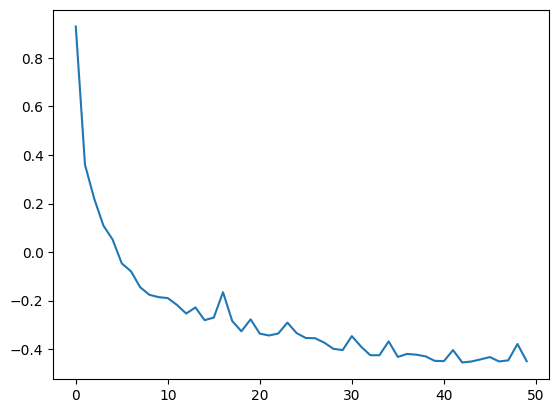

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) time64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
  * latitude   (latitude) float64 28.2 28.21 28.22 28.23 ... 28.97 28.98 28.99
  * longitude  (longitude) float64 76.85 76.86 76.87 76.88 ... 77.62 77.63 77.64
Data variables:
    P25        (time, latitude, longitude) float32 120.6 127.0 ... 117.4 112.5

16.150426864624023

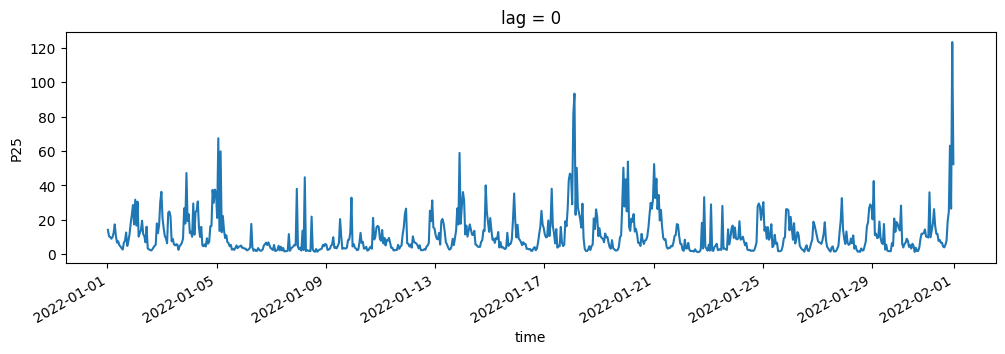

100%|██████████| 6/6 [04:44<00:00, 47.46s/it]


|   context_sampling | rmse         | IDW_rmse     |
|-------------------:|:-------------|:-------------|
|               0.01 | 34.33 ± 0.67 | 50.83 ± 1.90 |
|               0.02 | 26.89 ± 0.78 | 49.62 ± 1.66 |
|               0.05 | 18.43 ± 0.36 | 48.71 ± 0.71 |
|               0.1  | 13.73 ± 0.45 | 48.25 ± 0.50 |
|               0.2  | 11.06 ± 0.23 | 48.33 ± 0.29 |
|               0.5  | 9.96 ± 0.13  | 48.16 ± 0.24 |


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:51<00:00, 28.62s/it]


|   context_sampling | rmse         |
|-------------------:|:-------------|
|               0.01 | 18.53 ± 0.04 |
|               0.02 | 15.30 ± 0.32 |
|               0.05 | 10.74 ± 0.14 |
|               0.1  | 8.38 ± 0.13  |
|               0.2  | 6.64 ± 0.07  |
|               0.5  | 6.79 ± 0.01  |


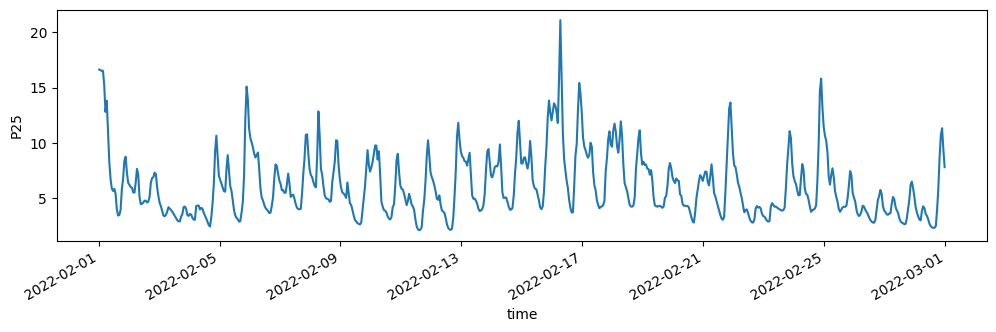

In [44]:
test_res_xr = res_df.to_xarray()
test_res_idw = idw_df.to_xarray()
test_res_krig = krig_df.to_xarray()
# convert xarray to float
mean_std = pd.DataFrame(
    index=test_res_xr.context_sampling.values, columns=["ConvGNP", "IDW", "Kriging"]
)
for cs in test_res_xr.context_sampling.values:
    mean = test_res_xr.sel(context_sampling=cs)["rmse"].mean().item()
    std = test_res_xr.sel(context_sampling=cs)["rmse"].std().item()
    mean_std.loc[cs, "ConvGNP"] = f"{mean:.2f} ± {std:.2f}"
    mean = test_res_idw.sel(context_sampling=cs)["rmse"].mean().item()
    std = test_res_idw.sel(context_sampling=cs)["rmse"].std().item()
    mean_std.loc[cs, "IDW"] = f"{mean:.2f} ± {std:.2f}"
    try:
        mean = test_res_krig.sel(context_sampling=cs)["rmse"].mean().item()
        std = test_res_krig.sel(context_sampling=cs)["rmse"].std().item()
        mean_std.loc[cs, "Kriging"] = f"{mean:.2f} ± {std:.2f}"
    except KeyError:
        pass
mean_std.index.name = "fraction of context"
print(mean_std.to_markdown())


|   fraction of context | ConvGNP      | IDW          | Kriging      |
|----------------------:|:-------------|:-------------|:-------------|
|                  0.01 | 18.07 ± 0.56 | 29.81 ± 0.66 | 30.85 ± 0.76 |
|                  0.02 | 14.77 ± 0.31 | 29.22 ± 0.39 | 30.29 ± 0.32 |
|                  0.05 | 10.72 ± 0.08 | 29.02 ± 0.27 | 30.18 ± 0.08 |
|                  0.1  | 8.25 ± 0.14  | 28.84 ± 0.16 | nan          |


|   context_sampling | rmse         | IDW_rmse     |
|-------------------:|:-------------|:-------------|
|               0.01 | 18.07 ± 0.56 | 29.81 ± 0.66 |
|               0.02 | 14.77 ± 0.31 | 29.22 ± 0.39 |
|               0.05 | 10.72 ± 0.08 | 29.02 ± 0.27 |
|               0.1  | 8.25 ± 0.14  | 28.84 ± 0.16 |

|   context_sampling | rmse         | IDW_rmse     |
|-------------------:|:-------------|:-------------|
|               0.01 | 34.33 ± 0.67 | 50.83 ± 1.90 |
|               0.02 | 26.89 ± 0.78 | 49.62 ± 1.66 |
|               0.05 | 18.43 ± 0.36 | 48.71 ± 0.71 |
|               0.1  | 13.73 ± 0.45 | 48.25 ± 0.50 |
|               0.2  | 11.06 ± 0.23 | 48.33 ± 0.29 |
|               0.5  | 9.96 ± 0.13  | 48.16 ± 0.24 |

## Only on ConvGNP

In [ ]:
scaled_test_ds = data_processor(simulation_test_ds)
task_loader = TaskLoader(scaled_test_ds, scaled_test_ds)

res_df = pd.DataFrame(columns=["context_sampling", "seed", "rmse"]).set_index(
    ["context_sampling", "seed"]
)
for context_sampling in tqdm([0.01, 0.02, 0.05, 0.1, 0.2, 0.5]):
    for seed in tqdm(range(3)):
        np.random.seed(seed)
        test_tasks = []
        idw_ds_list = []
        for date in scaled_test_ds.time.values:
            task = task_loader(
                date,
                context_sampling=context_sampling,
                target_sampling="all",
                seed_override=seed,
            )
            test_tasks.append(task)

        mean_ds, scale_ds = model.predict(test_tasks, simulation_test_ds)
        errors = np.abs(mean_ds - simulation_test_ds).mean(
            dim={"latitude", "longitude"}
        )
        rmse = np.sqrt((errors**2).mean(dim="time"))["P25"].item()
        res_df.loc[(context_sampling, seed), "rmse"] = rmse

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 6/6 [02:51<00:00, 28.62s/it]


In [ ]:
test_res_xr = res_df.to_xarray()
# test_res_idw = idw_df.to_xarray()
# convert xarray to float
mean_std = pd.DataFrame(index=test_res_xr.context_sampling.values, columns=["rmse"])
for cs in test_res_xr.context_sampling.values:
    mean = test_res_xr.sel(context_sampling=cs)["rmse"].mean().item()
    std = test_res_xr.sel(context_sampling=cs)["rmse"].std().item()
    mean_std.loc[cs, "rmse"] = f"{mean:.2f} ± {std:.2f}"
    # mean = test_res_idw.sel(context_sampling=cs)["rmse"].mean().item()
    # std = test_res_idw.sel(context_sampling=cs)["rmse"].std().item()
    # mean_std.loc[cs, "IDW_rmse"] = f"{mean:.2f} ± {std:.2f}"
mean_std.index.name = "context_sampling"
print(mean_std.to_markdown())

|   context_sampling | rmse         |
|-------------------:|:-------------|
|               0.01 | 18.53 ± 0.04 |
|               0.02 | 15.30 ± 0.32 |
|               0.05 | 10.74 ± 0.14 |
|               0.1  | 8.38 ± 0.13  |
|               0.2  | 6.64 ± 0.07  |
|               0.5  | 6.79 ± 0.01  |


|   context_sampling | rmse         |
|-------------------:|:-------------|
|               0.01 | 18.53 ± 0.04 |
|               0.02 | 15.30 ± 0.32 |
|               0.05 | 10.74 ± 0.14 |
|               0.1  | 8.38 ± 0.13  |
|               0.2  | 6.64 ± 0.07  |
|               0.5  | 6.79 ± 0.01  |

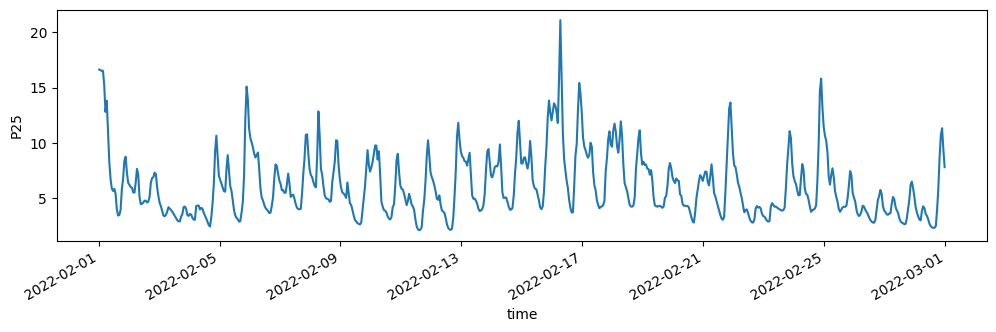

In [ ]:
errors["P25"].plot(figsize=(12, 3))


## Active Learning on station

In [54]:
station_ds = load_station_ds()
# caaqm = load_caaqm(years=2022, months=2, variables="PM2.5").load()
# caaqm
station_ds

<xarray.Dataset>
Dimensions:    (station: 38)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
Data variables:
    latitude   (station) float64 ...
    longitude  (station) float64 ...

In [66]:
X_c_raw = np.array([station_ds.latitude, station_ds.longitude])
X_c_raw.shape, X_c_raw.dtype, type(X_c_raw)


((2, 38), dtype('float64'), numpy.ndarray)

In [76]:
X_c = data_processor.map_coord_array(X_c_raw)

task = task_loader(simulation_test_ds.time.values[0], (X_c,))
task

time: Timestamp/2022-02-01 00:30:00
flag: NoneType/None
X_c: ['ndarray/float32/(2, 38)']
Y_c: ['ndarray/float32/(1, 38)']
X_t: [('ndarray/float32/(1, 80)', 'ndarray/float32/(1, 80)')]
Y_t: ['ndarray/float32/(1, 80, 80)']

In [80]:
from deepsensor.active_learning.algorithms import GreedyAlgorithm


In [96]:
# greedy_alg = GreedyAlgorithm(
#     model=model,
#     X_t=pd.DataFrame(X_c.T, columns=["x1", "x2"]),
#     X_s=pd.DataFrame(
#         X_c.T, columns=["x1", "x2"]
#     ),  # Coarsen search points to speed up computation
#     N_new_context=10,
#     X_normalised=True,
# )


In [97]:
from deepsensor.active_learning.acquisition_fns import MeanStddev


In [275]:
# model.predict??


In [283]:
new = (
    caaqm.sel(station=station_ds.station.values)
    .to_dataframe()
    .reset_index()
    .set_index(["time", "latitude", "longitude"])
    .to_xarray()
).drop_vars("station")
new = new.to_dataframe().dropna()
new


PM2.5
time                latitude  longitude        
2022-02-01 00:30:00 28.470691 77.109936  113.18
                    28.498571 77.264840  199.25
                    28.530785 77.271255  235.75
                    28.531346 77.190156  219.00
                    28.550425 77.215938  189.00
...                                         ...
2022-02-28 23:30:00 28.732820 77.170633  110.75
                    28.750050 77.111261   87.87
                    28.776200 77.051074  232.00
                    28.815329 77.153010   80.00
                    28.822836 77.101981  115.25

[24585 rows x 1 columns]

In [284]:
new.reset_index().latitude.unique().shape

(38,)

In [285]:
new.loc[task["time"]].drop([]).shape

(37, 1)

In [286]:
test_tasks[0]["time"]

Timestamp('2022-02-01 00:30:00')

In [287]:
len(test_tasks) == 24 * 7

False

In [345]:
chosen_idx = []

for al in range(10):
    print(f"AL: {al}")
    mean_dfs = []
    std_dfs = []
    create_init = time()
    test_tasks = []
    delayed = dask.delayed(task_loader)
    for date in scaled_test_ds.time.values[: 24 * 7]:
        task = delayed(
            date,
            context_sampling=1.0,
            target_sampling="all",
            seed_override=3,
        )
        test_tasks.append(task)
    print(f"Append Time: {time() - create_init:.2f}", end=" ")
    test_tasks = dask.compute(*test_tasks)
    print(f"Create Time: {time() - create_init:.2f}", end=" ")

    for task in test_tasks:
        if len(chosen_idx) > 0:
            try:
                to_add = data_processor(
                    master_mean_df.loc[task["time"]].loc[chosen_idx]
                )
                x = to_add.reset_index()[["x1", "x2"]].values.T
                task["X_c"][0] = np.concatenate([task["X_c"][0], x], axis=1)
                task["Y_c"][0] = np.concatenate(
                    [task["Y_c"][0], to_add[["P25"]].values.T], axis=1
                )
            except KeyError:
                pass
        try:
            check_df = new.loc[task["time"]].drop(chosen_idx)
        except KeyError:
            print("KeyError")
            check_df = new.loc[task["time"]]
        # print(check_df.shape)
        mean_df, std_df = model.predict(task, check_df)
        mean_dfs.append(mean_df)
        std_dfs.append(std_df)
    master_mean_df = pd.concat(mean_dfs)
    std_df = pd.concat(std_dfs)
    avg_std_df = (
        std_df.reset_index().groupby(["latitude", "longitude"]).agg({"P25": "mean"})
    )
    avg_std_df["P25"] = avg_std_df["P25"].astype(np.float32)
    best_loc = avg_std_df.idxmax().values[0]
    chosen_idx.append(best_loc)

AL: 0
Append Time: 0.01 

KeyboardInterrupt: 

In [305]:
chosen_idx


[(28.5627763, 77.1180053),
 (28.672342, 77.31526),
 (28.563262, 77.186937),
 (28.5504249, 77.2159377),
 (28.672342, 77.31526),
 (28.672342, 77.31526)]

In [340]:
gdf = load_shapefile("delhi")

# lats = [i[0] for i in chosen_idx]
# lons = [i[1] for i in chosen_idx]
seed = 1
station_df = station_ds.to_dataframe().reset_index()
init_df = station_df.sample(10, replace=False, random_state=seed)
remaining_df = station_df.drop(init_df.index)
placed_df = remaining_df.sample(10, replace=False, random_state=seed)
remaining_df = remaining_df.drop(placed_df.index)
print(init_df.shape, placed_df.shape, remaining_df.shape)

(10, 3) (10, 3) (18, 3)


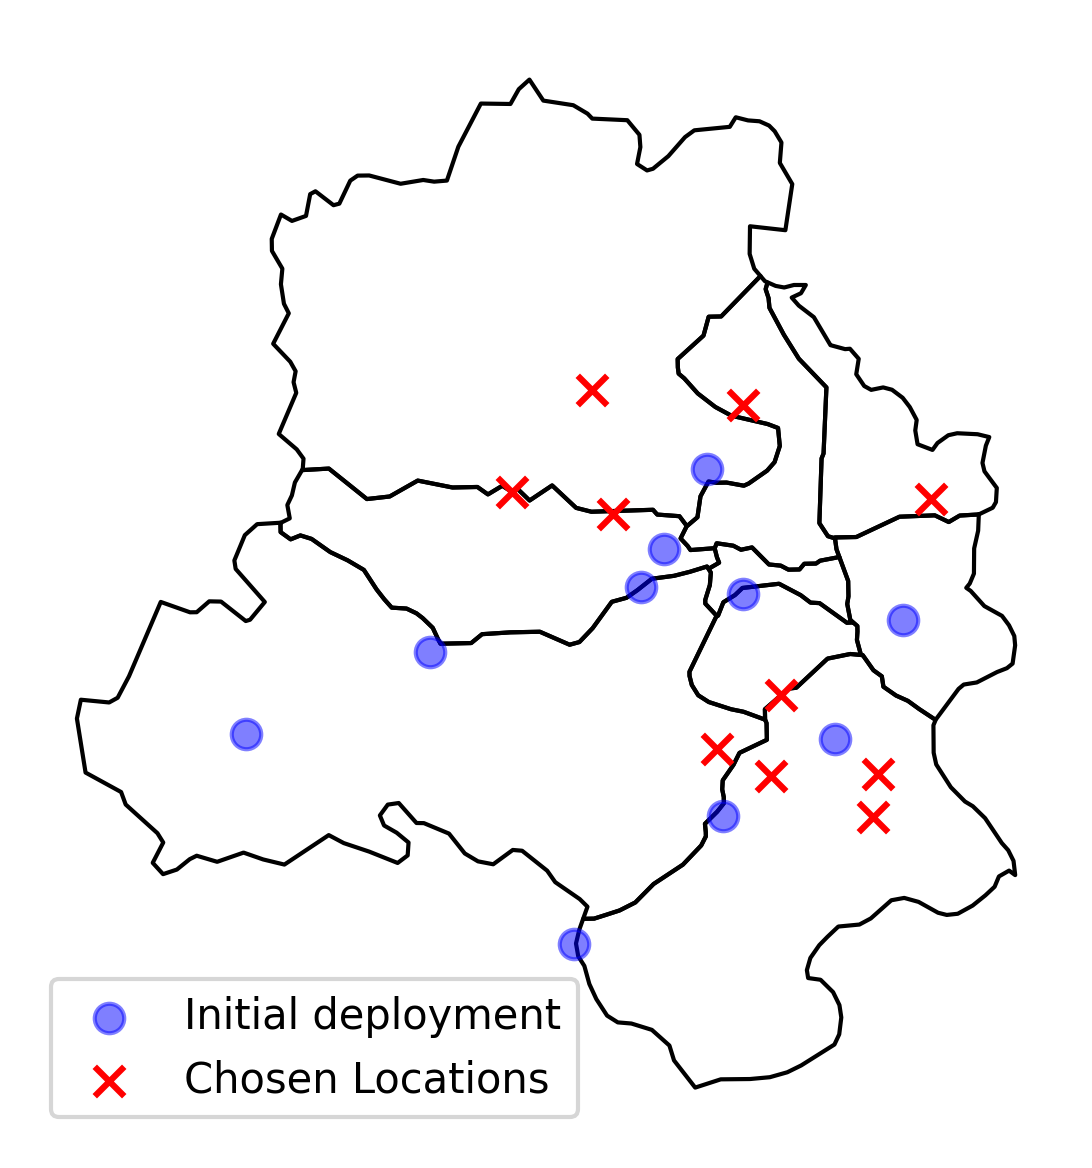

In [344]:
plt.figure(dpi=300)
ax = plt.gca()
gdf.plot(color="none", ax=ax)
ax.scatter(
    init_df.longitude,
    init_df.latitude,
    color="blue",
    s=50,
    label="Initial deployment",
    alpha=0.5,
)
ax.scatter(
    placed_df.longitude,
    placed_df.latitude,
    color="red",
    s=50,
    marker="x",
    label="Chosen Locations",
)
# turn off axis
ax.axis("off")
ax.legend(loc="lower left")